# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Загрузка и ознакомление с данными

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import lightgbm
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('autos.csv')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
data.corr()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
Price,1.000000,0.026916,0.158872,-0.333199,0.110581,NaN,0.076055
RegistrationYear,0.026916,1.000000,-0.000828,-0.053447,-0.011619,NaN,-0.003459
Power,0.158872,-0.000828,1.000000,0.024002,0.043380,NaN,0.021665
Kilometer,-0.333199,-0.053447,0.024002,1.000000,0.009571,NaN,-0.007698
RegistrationMonth,0.110581,-0.011619,0.043380,0.009571,1.000000,NaN,0.013995
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostalCode,0.076055,-0.003459,0.021665,-0.007698,0.013995,NaN,1.000000


### Удаление столбцов не влияющих на результат модели

На стоимость автомобиля не должны влиять следующие параметры:
1. DateCrawled — дата скачивания анкеты из базы
2. DateCreated — дата создания анкеты
3. PostalCode — почтовый индекс владельца анкеты (пользователя)
4. LastSeen — дата последней активности пользователя
5. NumberOfPictures — количество фотографий автомобиля
6. RegistrationMonth — месяц регистрации автомобиля

In [5]:
data = data.drop(['DateCrawled', 'DateCreated', 'PostalCode', 'LastSeen', 'NumberOfPictures', 'RegistrationMonth'], axis = 1)
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


### Обработка пропусков

In [6]:
data.isna().sum()

Price                   0
VehicleType         37490
RegistrationYear        0
Gearbox             19833
Power                   0
Model               19705
Kilometer               0
FuelType            32895
Brand                   0
Repaired            71154
dtype: int64

In [7]:
pd.DataFrame(round(data.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
Price,0.000000
VehicleType,11.000000
RegistrationYear,0.000000
Gearbox,6.000000
Power,0.000000
Model,6.000000
Kilometer,0.000000
FuelType,9.000000
Brand,0.000000
Repaired,20.000000


Так как параметр model один из ключевых и пропусков в данном столбце 6%, удалим строки с пропусками у этого параметра

Остальные пропуски заполним значением unknown

In [8]:
data['VehicleType'] = data['VehicleType'].fillna('unknown')
data['Gearbox'] = data['Gearbox'].fillna('unknown')
data['FuelType'] = data['FuelType'].fillna('unknown')
data['Repaired'] = data['Repaired'].fillna('unknown')

In [9]:
data.isna().sum()

Price                   0
VehicleType             0
RegistrationYear        0
Gearbox                 0
Power                   0
Model               19705
Kilometer               0
FuelType                0
Brand                   0
Repaired                0
dtype: int64

In [10]:
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334664 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             334664 non-null  int64 
 1   VehicleType       334664 non-null  object
 2   RegistrationYear  334664 non-null  int64 
 3   Gearbox           334664 non-null  object
 4   Power             334664 non-null  int64 
 5   Model             334664 non-null  object
 6   Kilometer         334664 non-null  int64 
 7   FuelType          334664 non-null  object
 8   Brand             334664 non-null  object
 9   Repaired          334664 non-null  object
dtypes: int64(4), object(6)
memory usage: 28.1+ MB


### Поиск дубликатов

In [11]:
data.duplicated().sum()

43696

Найденные дубликаты необязательно являются ими, так как характеристики машин могут совпадать. Даже если это все таки дубликаты, она не должны сильно повлиять на результат модели

In [12]:
data['VehicleType'].sort_values().unique()

array(['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv',
       'unknown', 'wagon'], dtype=object)

In [13]:
data['Gearbox'].sort_values().unique()

array(['auto', 'manual', 'unknown'], dtype=object)

In [14]:
data['Model'].sort_values().unique()

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

In [15]:
data['FuelType'].sort_values().unique()

array(['cng', 'electric', 'gasoline', 'hybrid', 'lpg', 'other', 'petrol',
       'unknown'], dtype=object)

In [16]:
data['Brand'].sort_values().unique()

array(['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen',
       'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai',
       'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda',
       'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot',
       'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart',
       'subaru', 'suzuki', 'toyota', 'trabant', 'volkswagen', 'volvo'],
      dtype=object)

In [17]:
data['Repaired'].sort_values().unique()

array(['no', 'unknown', 'yes'], dtype=object)

### Проверка данных на аномальные значения

In [18]:
data.describe()

,Price,RegistrationYear,Power,Kilometer
count,334664.000000,334664.000000,334664.000000,334664.000000
mean,4504.346790,2003.923992,111.373195,128562.588148
std,4531.438572,69.377219,185.156439,37205.926976
min,0.000000,1000.000000,0.000000,5000.000000
25%,1150.000000,1999.000000,70.000000,125000.000000
50%,2800.000000,2003.000000,105.000000,150000.000000
75%,6500.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


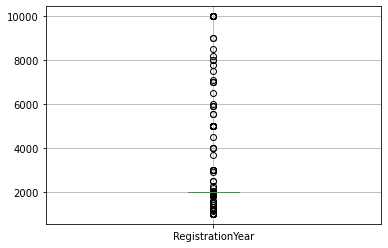

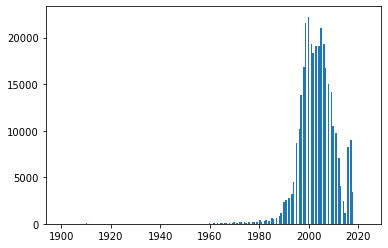

In [19]:
data.boxplot('RegistrationYear')
plt.show()
plt.hist(data['RegistrationYear'], 200, (1900, 2023))
plt.show()

In [20]:
data = data[data['RegistrationYear']>1980]
data = data[data['RegistrationYear']<2023]

Скорее всего машины зарегестрированные ранее 1980 года уже не актуальны, а позже 2023 зарегестрированы быть не могут

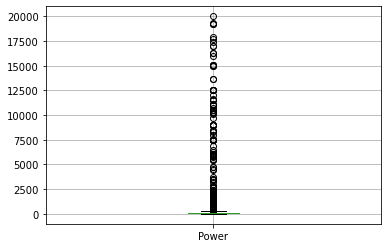

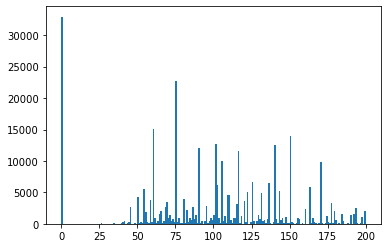

In [21]:
data.boxplot('Power')
plt.show()
plt.hist(data['Power'], 200, (0, 200))
plt.show()

In [22]:
data = data[data['Power']>0]
data = data[data['Power']<200]

Мощность не может быть равна 0, поэтому данные с мощностью = 0 являются аномальными. Значения больше 200 лошадиних сил, тоже выглидят аномальными

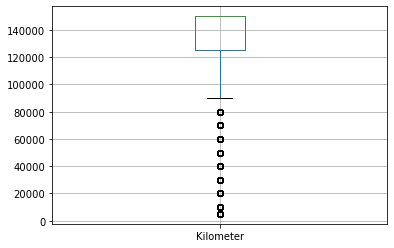

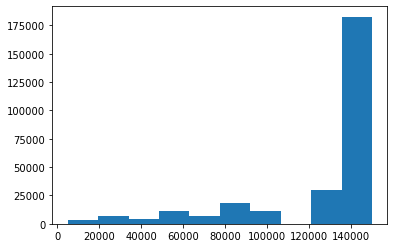

In [23]:
data.boxplot('Kilometer')
plt.show()
plt.hist(data['Kilometer'], 10, (5000, 150000))
plt.show()

Из первого графика видно, что значения менее 80000 являются выбросами, но удалять их не будем, так как на практике такое вполне возможно

In [24]:
data.describe()

,Price,RegistrationYear,Power,Kilometer
count,275188.000000,275188.000000,275188.000000,275188.000000
mean,4293.857650,2003.438526,109.886885,128328.597177
std,4227.335692,6.356068,38.389999,36758.201081
min,0.000000,1981.000000,1.000000,5000.000000
25%,1200.000000,1999.000000,75.000000,125000.000000
50%,2800.000000,2003.000000,105.000000,150000.000000
75%,6000.000000,2008.000000,140.000000,150000.000000
max,20000.000000,2019.000000,199.000000,150000.000000


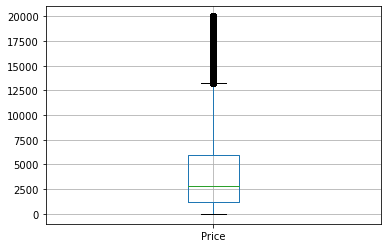

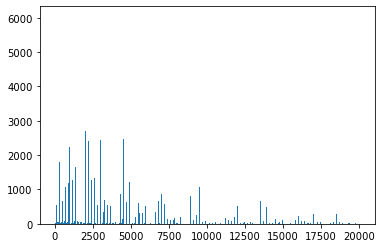

In [25]:
data.boxplot('Price')
plt.show()
plt.hist(data['Price'], 2000, (0, 20000))
plt.show()

In [26]:
data = data[data['Price']>100]

### Промежуточные выводы:

1. Данные загружены и изучены
2. Удалены признаки не влияющие на стоимость автомобиля
3. Устранены пропущенные значения
4. Данные проверены на дубликаты
5. Удалены данные с аномальными значениями параметров

## Обучение моделей

### Подготовка данных к обучению моделей

#### Деление данных на обучающую, валидационную и тестовую выборки

In [27]:
features = data.drop('Price', axis=1)
target = data['Price']
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.4, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state=12345)
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(160891, 9)
(53630, 9)
(53631, 9)


#### Кодирование категориальных признаков

In [28]:
%%time
enc = OneHotEncoder(sparse=False, handle_unknown='ignore')
category = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
features_train1 = features_train.copy()
enc.fit(features_train1[category])
features_train1[enc.get_feature_names()] = enc.transform(features_train1[category])
features_train1 = features_train1.drop(category, axis=1)
features_train1.head()

CPU times: total: 7.3 s
Wall time: 7.34 s


,RegistrationYear,Power,Kilometer,x0_bus,x0_convertible,x0_coupe,x0_other,x0_sedan,x0_small,x0_suv,...,x4_smart,x4_subaru,x4_suzuki,x4_toyota,x4_trabant,x4_volkswagen,x4_volvo,x5_no,x5_unknown,x5_yes
162369,2005,105,150000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
94519,2002,116,150000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
94232,1998,136,150000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
255,2002,101,150000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6507,2000,79,150000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [29]:
%%time
features_valid1 = features_valid.copy()
features_valid1[enc.get_feature_names()] = enc.transform(features_valid1[category])
features_valid1 = features_valid1.drop(category, axis=1)
features_test1 = features_test.copy()
features_test1[enc.get_feature_names()] = enc.transform(features_test1[category])
features_test1 = features_test1.drop(category, axis=1)

CPU times: total: 10.4 s
Wall time: 10.4 s


#### Масштабирование данных

In [30]:
numeric = ['RegistrationYear', 'Power', 'Kilometer']

scaler = StandardScaler()
scaler.fit(features_train1[numeric])
features_train1[numeric] = scaler.transform(features_train1[numeric])
features_valid1[numeric] = scaler.transform(features_valid1[numeric])
features_test1[numeric] = scaler.transform(features_test1[numeric])
features_train1.head()

,RegistrationYear,Power,Kilometer,x0_bus,x0_convertible,x0_coupe,x0_other,x0_sedan,x0_small,x0_suv,...,x4_smart,x4_subaru,x4_suzuki,x4_toyota,x4_trabant,x4_volkswagen,x4_volvo,x5_no,x5_unknown,x5_yes
162369,0.235056,-0.133643,0.594873,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
94519,-0.239935,0.153455,0.594873,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
94232,-0.873256,0.675452,0.594873,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
255,-0.239935,-0.238042,0.594873,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6507,-0.556595,-0.812239,0.594873,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


#### Промежуточные выводы:

1. Данные разделены на обучающую, валидационную и тестовую выборки в соотношении 3:1:1 соответственно
2. Проведено кодирование категориальных признаков
3. Проведено масштабирование данных

### Обучение моделей

In [31]:
result_models = []
state = 12345

#### Константная модель

In [32]:
%%time
predicted_valid = [target_train.mean()]*len(target_valid)

CPU times: total: 0 ns
Wall time: 0 ns


In [33]:
rmse = mean_squared_error(target_valid, predicted_valid)**0.5
print(f'RMSE: {rmse}')
result_models.append(['Константная модель', None, rmse, None, '0ns', None])

RMSE: 4204.620134769037


#### Линейная регрессия

In [34]:
model = LinearRegression() 

In [35]:
%%time
model.fit(features_train1, target_train)

CPU times: total: 8.3 s
Wall time: 2.59 s


LinearRegression()

In [36]:
%%time
predicted_valid = model.predict(features_valid1)

CPU times: total: 125 ms
Wall time: 122 ms


In [37]:
rmse = mean_squared_error(target_valid, predicted_valid)**0.5
print(f'RMSE: {rmse}')
result_models.append(['Линейная регрессия', None, rmse, '2.59s', '277ms', model])

RMSE: 2551239430465.996


Результат очень превышает необходимые значения, время обучения долгое.

#### Масштабирование и кодирование данных для моделей решающее дерево и случайный лес

In [38]:
%%time
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
enc.fit(features_train)
features_train2 = pd.DataFrame(enc.transform(features_train), columns=features_train.columns)
features_train2.head()

CPU times: total: 281 ms
Wall time: 272 ms


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,5.0,24.0,1.0,102.0,27.0,12.0,2.0,1.0,0.0
1,4.0,21.0,1.0,113.0,11.0,12.0,6.0,2.0,0.0
2,8.0,17.0,1.0,133.0,160.0,12.0,6.0,24.0,0.0
3,4.0,21.0,1.0,98.0,225.0,12.0,6.0,24.0,0.0
4,0.0,19.0,1.0,76.0,192.0,12.0,6.0,27.0,0.0


In [39]:
%%time
features_valid2 = pd.DataFrame(enc.transform(features_valid), columns=features_valid.columns)
features_test2 = pd.DataFrame(enc.transform(features_test), columns=features_test.columns)

CPU times: total: 188 ms
Wall time: 179 ms


In [40]:
numeric = features_train.columns

scaler = StandardScaler()
scaler.fit(features_train2[numeric])
features_train2[numeric] = scaler.transform(features_train2[numeric])
features_valid2[numeric] = scaler.transform(features_valid2[numeric])
features_test2[numeric] = scaler.transform(features_test2[numeric])
features_train2.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,0.143912,0.235056,0.353336,-0.133708,-1.153179,0.517919,-1.497870,-1.555470,-0.525608
1,-0.270029,-0.239935,0.353336,0.153424,-1.389088,0.517919,0.621339,-1.477964,-0.525608
2,1.385735,-0.873256,0.353336,0.675481,0.807813,0.517919,0.621339,0.227174,-0.525608
3,-0.270029,-0.239935,0.353336,-0.238119,1.766192,0.517919,0.621339,0.227174,-0.525608
4,-1.925792,-0.556595,0.353336,-0.812382,1.279630,0.517919,0.621339,0.459693,-0.525608


#### Решающее дерево

In [41]:
result = []
for depth in range(1, 100, 5):
    model = DecisionTreeRegressor(random_state=state, max_depth=depth) 
    model.fit(features_train2, target_train)  
    predicted_valid = model.predict(features_valid2)
    rmse = mean_squared_error(target_valid, predicted_valid)**0.5
    result.append([depth, rmse])

In [42]:
result = pd.DataFrame(data=result, columns=['depth', 'rmse'])
result

,depth,rmse
0,1,3328.745890
1,6,2104.092296
2,11,1753.952589
3,16,1683.833292
4,21,1720.073603
5,26,1726.327276
6,31,1720.046832
7,36,1730.791804
8,41,1728.621394
9,46,1728.621394


Наилучший результат у модели с глубиной дерева 16.
Первый возможно подходящий результут у модели с глубиной дерева 6. Посмотрим на время обучения и предсказания данных моделей

In [43]:
model = DecisionTreeRegressor(random_state=state, max_depth=6)

In [44]:
%%time
model.fit(features_train2, target_train) 

CPU times: total: 219 ms
Wall time: 220 ms


DecisionTreeRegressor(max_depth=6, random_state=12345)

In [45]:
%%time
predicted_valid = model.predict(features_valid2)

CPU times: total: 0 ns
Wall time: 6 ms


In [46]:
rmse = mean_squared_error(target_valid, predicted_valid)**0.5
result_models.append(['Решающее дерево', 'depth = 6', rmse, '220ms', '6ms', model])

In [47]:
model = DecisionTreeRegressor(random_state=state, max_depth=16)

In [48]:
%%time
model.fit(features_train2, target_train) 

CPU times: total: 406 ms
Wall time: 413 ms


DecisionTreeRegressor(max_depth=16, random_state=12345)

In [49]:
%%time
predicted_valid = model.predict(features_valid2)

CPU times: total: 31.2 ms
Wall time: 15 ms


In [50]:
rmse = mean_squared_error(target_valid, predicted_valid)**0.5
result_models.append(['Решающее дерево', 'depth = 16', rmse, '413ms', '15ms', model])

#### Случайный лес

In [51]:
result = []
for est in [1, 100, 200, 300]:
    model = RandomForestRegressor(random_state=12345, n_estimators=est) 
    model.fit(features_train2, target_train)  
    predicted_valid = model.predict(features_valid2)
    rmse = mean_squared_error(target_valid, predicted_valid)**0.5
    result.append([est, rmse])

In [52]:
result = pd.DataFrame(data=result, columns=['est', 'rmse'])
result

,est,rmse
0,1,1827.442310
1,100,1443.847791
2,200,1442.191600
3,300,1441.826452


Проверим время выполнения модели с количеством деревьев - 100

In [53]:
model = RandomForestRegressor(random_state=12345, n_estimators=100)

In [54]:
%%time
model.fit(features_train2, target_train)

CPU times: total: 38.3 s
Wall time: 38.5 s


RandomForestRegressor(random_state=12345)

In [55]:
%%time
predicted_valid = model.predict(features_valid2)

CPU times: total: 1.83 s
Wall time: 1.83 s


In [56]:
rmse = mean_squared_error(target_valid, predicted_valid)**0.5
result_models.append(['Случайный лес', 'est = 100', rmse, '38.5s', '1.83s', model])

Значение rmse у моделей случайного леса значительно лучше, чем у решающего дерева, но время выполнения очень долгое, что не подходит для достижения цели

#### Градиентный бустинг

##### CatBoots

In [57]:
numeric = ['RegistrationYear', 'Power', 'Kilometer']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train3 = features_train.copy()
features_valid3 = features_valid.copy()
features_test3 = features_test.copy()
features_train3[numeric] = scaler.transform(features_train3[numeric])
features_valid3[numeric] = scaler.transform(features_valid3[numeric])
features_test3[numeric] = scaler.transform(features_test3[numeric])
features_train3.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
162369,small,0.235056,manual,-0.133643,a3,0.594873,gasoline,audi,no
94519,sedan,-0.239935,manual,0.153455,3er,0.594873,petrol,bmw,no
94232,wagon,-0.873256,manual,0.675452,omega,0.594873,petrol,opel,no
255,sedan,-0.239935,manual,-0.238042,vectra,0.594873,petrol,opel,no
6507,bus,-0.556595,manual,-0.812239,scenic,0.594873,petrol,renault,no


In [58]:
model = CatBoostRegressor(loss_function='RMSE', iterations=200, cat_features=category)

In [59]:
%%time
model.fit(features_train3, target_train, verbose=25)

Learning rate set to 0.338123
0:	learn: 3306.0158577	total: 291ms	remaining: 57.9s
25:	learn: 1592.6879057	total: 3.18s	remaining: 21.3s
50:	learn: 1518.9874336	total: 6.04s	remaining: 17.7s
75:	learn: 1475.7505663	total: 8.92s	remaining: 14.6s
100:	learn: 1452.3034349	total: 11.8s	remaining: 11.5s
125:	learn: 1436.0466248	total: 14.6s	remaining: 8.6s
150:	learn: 1422.6562817	total: 17.6s	remaining: 5.7s
175:	learn: 1408.4723023	total: 20.5s	remaining: 2.79s
199:	learn: 1399.6288334	total: 23.1s	remaining: 0us
CPU times: total: 2min 3s
Wall time: 23.9 s


In [60]:
%%time
predicted_valid = model.predict(features_valid3)

CPU times: total: 375 ms
Wall time: 153 ms


In [61]:
rmse = mean_squared_error(target_valid, predicted_valid)**0.5
result_models.append(['CatBoots', 'iterations = 500', rmse, '23.9s', '153ms', model])

##### LightGBM

In [62]:
features_train4 = features_train3.copy()
features_valid4 = features_valid3.copy()
features_test4 = features_test3.copy()
features_train4[category] = features_train4[category].astype('category')
features_valid4[category] = features_valid4[category].astype('category')
features_test4[category] = features_test4[category].astype('category')

In [63]:
result = []
for leave in [100, 200, 300]:
    model = lightgbm.LGBMRegressor(random_state=state, num_leaves=leave)
    model.fit(features_train4, target_train)  
    predicted_valid = model.predict(features_valid4)
    rmse = mean_squared_error(target_valid, predicted_valid)**0.5
    result.append([leave, rmse])

In [64]:
result = pd.DataFrame(data=result, columns=['leave', 'rmse'])
result

,leave,rmse
0,100,1371.564885
1,200,1351.563969
2,300,1346.947234


In [65]:
result = []
for est in [100, 200, 300]:
    model = lightgbm.LGBMRegressor(random_state=state, num_leaves=300, n_estimators=est)
    model.fit(features_train4, target_train)  
    predicted_valid = model.predict(features_valid4)
    rmse = mean_squared_error(target_valid, predicted_valid)**0.5
    result.append([est, rmse])

In [66]:
result = pd.DataFrame(data=result, columns=['est', 'rmse'])
result

,est,rmse
0,100,1346.947234
1,200,1340.849791
2,300,1340.932450


In [67]:
model = lightgbm.LGBMRegressor(random_state=state, num_leaves=300, n_estimators=200)

In [68]:
%%time
model.fit(features_train4, target_train)

CPU times: total: 17.2 s
Wall time: 2.27 s


LGBMRegressor(n_estimators=200, num_leaves=300, random_state=12345)

In [69]:
%%time
predicted_valid = model.predict(features_valid4)

CPU times: total: 2.53 s
Wall time: 328 ms


In [70]:
rmse = mean_squared_error(target_valid, predicted_valid)**0.5
result_models.append(['LightGBM', 'leave=300, est=200', rmse, '2.27s', '328ms', model])

### Промежуточные выводы:
1. Обучены 6 моделей с различными гиперпараметрами
2. Константная модель и линейная регрессия показали наихудшие результаты по метрике rmse
3. Остальные модели показали хорошие результаты метрики rmse

## Анализ моделей

### Сравнение моделей по поставленным критериям

In [71]:
result = pd.DataFrame(data=result_models, 
                      columns=['Название модели', 'Гиперпараметры', 'RMSE', 'Время обучения', 'Время предсказания', 'Модель'])
result

,Название модели,Гиперпараметры,RMSE,Время обучения,Время предсказания,Модель
0,Константная модель,None,4.204620e+03,None,0ns,None
1,Линейная регрессия,None,2.551239e+12,2.59s,277ms,LinearRegression()
2,Решающее дерево,depth = 6,2.104092e+03,220ms,6ms,"DecisionTreeRegressor(max_depth=6, random_stat..."
3,Решающее дерево,depth = 16,1.683833e+03,413ms,15ms,"DecisionTreeRegressor(max_depth=16, random_sta..."
4,Случайный лес,est = 100,1.443848e+03,38.5s,1.83s,"(DecisionTreeRegressor(max_features='auto', ra..."
5,CatBoots,iterations = 500,1.432722e+03,23.9s,153ms,<catboost.core.CatBoostRegressor object at 0x0...
6,LightGBM,"leave=300, est=200",1.340850e+03,2.27s,328ms,"LGBMRegressor(n_estimators=200, num_leaves=300..."


По метрике RMSE наилучшая модель LightGBM с гиперпараметрами leave=300, est=200.

По времени обучения и предсказания наилучшая модель решающее дерево с гиперпаметрами depth=6.

Но у этих моделей значительно выше второй рассматриваемый параметр.

У модели решающее дерево (depth=16) значение метрики RMSE немного выше, чем у LightGBM, зато время обучения гораздо меньше. Будем считать, что данная модель наиболее удачно подходит для решения поставленной задачи. Проверим выбранную модель на тестовой выборке.

In [72]:
final_model = result.loc[3]

In [73]:
%%time
predicted_test = final_model['Модель'].predict(features_test2)

CPU times: total: 15.6 ms
Wall time: 33.1 ms


In [74]:
final_model['RMSE'] = mean_squared_error(target_test, predicted_test)**0.5
final_model['время предсказания тест'] = '33.1ms'
final_model

Название модели                                              Решающее дерево
Гиперпараметры                                                    depth = 16
RMSE                                                             1681.352608
Время обучения                                                         413ms
Время предсказания                                                      15ms
Модель                     DecisionTreeRegressor(max_depth=16, random_sta...
время предсказания тест                                               33.1ms
Name: 3, dtype: object

### Промежуточные выводы:
1. Рекомендованная модель CatBoot с гиперпараметрами iterations=500. Значение метрики RMSE на тестовой выборке равно 1496, что значительно меньше необходимого значения.

## Итоговые выводы:

### Ход работы:
1. Изучен набор данных, устранены пропущенные значения и удалены ненужные параметры.
2. Произведен поиск дубликатов, данные очищены от аномальных значений.
3. Набор данных был разделен на три выборки: обучающая выборка, валидационная выборка и тестовая выборка в соотношении 3:1:1 соответственно.
4. Проведено кодирование и масштабирование признаков.
5. Исследована константная модель.
6. Исследована модель линейной регрессии.
7. Исследована модель решающее дерево с различными гипперпараметрами от 1 до 100 с шагом 5
8. Исследована модель случайный лес с различными гипперпараметрами 1, 100, 200 и 300
9. Исследованы две модели градиентного бустинга:
- С помощью библиотеки CatBoots и iterations=200.
- С помощью библиотеки LightGBM и гиперпаметрами leave = 100, 200, 300, est 100, 200, 300 
10. Для наилучших моделей посчитано время обучения и предсказания.
11. Полученные результаты сведены в таблицу.
12. Выбрана наилучшая модели и протестирована на тестовых данных.

### Результаты:
1. Наилучшей моделью принимаем модель под номером 3 в сводной таблице: модель решающее дерево с гиперпараметрами depth = 16
2. Результаты на тестовой выборке представлены ниже
|                         |               |
|-------------------------|---------------|
|Имя модели               |Решающее дерево|
|iterations               |16             |
|RMSE                     |1681.352608    |
|Время обучения           |388ms          |
|Время предсказания       |13.3ms         |

Так значение метрики RMSE менее 2500 и время обучения не критически большое, можно считать, что поставленная цель достигнута. 